<a href="https://colab.research.google.com/github/AndrewCrossman/Research/blob/main/FitXRD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import optimize
from google.colab import files
import matplotlib.pylab as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Helper Functions and Values

In [160]:
def _1gaussian(x, a1,c1,s1):
    return a1*np.exp((-1.0/2.0)*(((x-c1)/s1)**2))

def _2gaussian(x, a1,c1,s1, a2,c2,s2):
  return _1gaussian(x,a1,c1,s1) + _1gaussian(x,a2,c2,s2)

def _5gaussian(x, a1,c1,s1, a2,c2,s2, a3,c3,s3, a4,c4,s4, a5,c5,s5):
  return _1gaussian(x,a1,c1,s1) + _1gaussian(x,a2,c2,s2) + _1gaussian(x,a3,c3,s3) + _1gaussian(x,a4,c4,s4) + _1gaussian(x,a5,c5,s5)

def _8gaussian(x, a1,c1,s1, a2,c2,s2, a3,c3,s3, a4,c4,s4, a5,c5,s5, a6,c6,s6, a7,c7,s7, a8,c8,s8):
  return _1gaussian(x,a1,c1,s1) + _1gaussian(x,a2,c2,s2) + _1gaussian(x,a3,c3,s3) + _1gaussian(x,a4,c4,s4) + _1gaussian(x,a5,c5,s5) + _1gaussian(x,a6,c6,s6) + _1gaussian(x,a7,c7,s7) + _1gaussian(x,a8,c8,s8)

def findLatticeParameter(v, h,k,l, theta):
  return v*np.sqrt(h*h + k*k + l*l) / (2*np.sin(theta/2*np.pi/180))

FCC_Peaks = [[0,1,1], [2,0,0], [2,2,0], [3,1,1], [2,2,2]]

## Extract Data and Name Variables

In [259]:
file = "https://raw.githubusercontent.com/AndrewCrossman/Research/main/Tests/MC_Sphere5050_AuPd_onAu_r25_5000Cycles/5000.xrd"
plotTitle = r'Relaxed AuPd Alloy XRD Gaussian Fits'
savename = 'RelaxedAuPdAlloyXRDFit.png'
data = pd.read_csv(file,header=None,delimiter=' ',skiprows=1)
theta2 = data.iloc[:,3]           # two theta values
intensity = data.iloc[:,11]        # intensity vales

In [260]:
data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,NaN,NaN,NaN,30.010355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,450.880793,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,30.020709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,451.195464,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,30.031064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,451.557780,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,30.041419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,451.885203,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,30.051774,NaN,NaN,NaN,NaN,NaN,NaN,NaN,452.157973,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8686,NaN,NaN,NaN,119.951303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,496.385148,NaN,NaN,NaN,NaN,NaN
8687,NaN,NaN,NaN,119.961657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,494.467202,NaN,NaN,NaN,NaN,NaN
8688,NaN,NaN,NaN,119.972012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,492.572791,NaN,NaN,NaN,NaN,NaN
8689,NaN,NaN,NaN,119.982367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,490.703915,NaN,NaN,NaN,NaN,NaN


In [261]:
# scale intenisty data to 1 and scale 2theta scan from 30-90 degrees
intensity = intensity/intensity.max()
intensity = intensity[:5796]
theta2 = theta2[:5796]

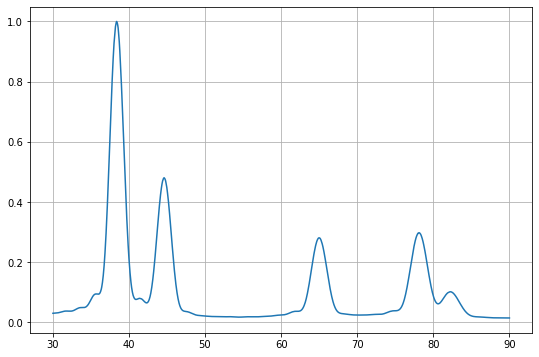

In [262]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(theta2,intensity)
ax.grid()

## Fit XRD using Gaussian Peaks

Parameters for the Gaussian Peaks

In [267]:
# Initial Peak Guesses
# amplitude, position/center, sigma
a1, c1, s1 = 1, 39.5, 1.5
a2, c2, s2 = .45, 46, 1.5
a3, c3, s3 = .28, 67, 2
a4, c4, s4 = .27, 80, 2
a5, c5, s5 = .11, 85, 2
''' 
a1, c1, s1 = 1, 40, 4
a2, c2, s2 = .2, 49, 4
a3, c3, s3 = .22, 65, 4
a4, c4, s4 = .22, 74, 4
a5, c5, s5 = .11, 89, 4
'''
a1, c1, s1 = 1, 39, 1.5
a2, c2, s2 = .45, 44, 1.5
a3, c3, s3 = .28, 65, 2
a4, c4, s4 = .3, 79, 2.4
a5, c5, s5 = .11, 81.5, 2.3

In [268]:
# Fit Data and Find Residuals
popt_5gauss, pcov_5gauss = optimize.curve_fit(_5gaussian, theta2, intensity, p0=[a1,c1,s1, a2,c2,s2, a3,c3,s3, a4,c4,s4, a5,c5,s5])
perr_5gauss = np.sqrt(np.diag(pcov_5gauss))
pars_1, pars_2, pars_3, pars_4,pars_5  = popt_5gauss[0:3], popt_5gauss[3:6], popt_5gauss[6:9], popt_5gauss[9:12], popt_5gauss[12:15]
gauss_peak_1 = _1gaussian(theta2, *pars_1)
gauss_peak_2 = _1gaussian(theta2, *pars_2)
gauss_peak_3 = _1gaussian(theta2, *pars_3)
gauss_peak_4 = _1gaussian(theta2, *pars_4)
gauss_peak_5 = _1gaussian(theta2, *pars_5)

residual_5gauss = intensity- (_5gaussian(theta2, *popt_5gauss))

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [269]:
# Find lattice parameter for each FCC Peak
v = 1.5406
peak_1 = np.append(pars_1,findLatticeParameter(v,1,1,1,pars_1[1]))
peak_2 = np.append(pars_2,findLatticeParameter(v,2,0,0,pars_2[1]))
peak_3 = np.append(pars_3,findLatticeParameter(v,2,2,0,pars_3[1]))
peak_4 = np.append(pars_4,findLatticeParameter(v,3,1,1,pars_4[1]))
peak_5 = np.append(pars_5,findLatticeParameter(v,2,2,2,pars_5[1]))
print('Amplitude | Position | FWHM | LP')
print(peak_1)
print(peak_2)
print(peak_3)
print(peak_4)
print(peak_5)

Amplitude | Position | FWHM | LP
[ 0.96443958 38.39899316  0.88613426  4.05706208]
[ 0.44626721 44.61877956  0.88416072  4.05839943]
[ 0.2393381  65.00203416  0.8644106   4.05486376]
[ 16.20805901 910.73514712 248.03245789   2.56604803]
[ -5.80344554 153.70303999   4.58457056   2.74023594]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

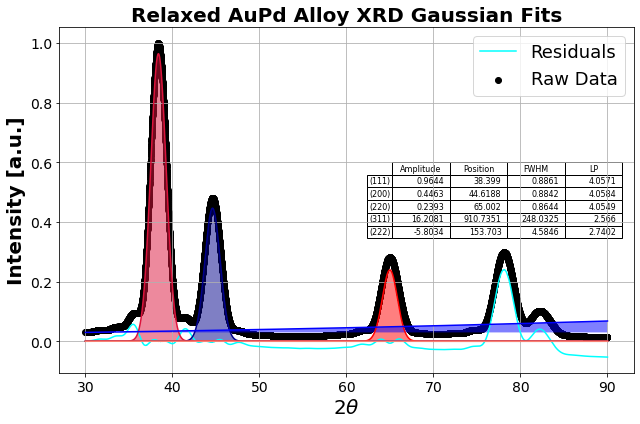

In [270]:
# Plot Data
fig, ax = plt.subplots(figsize=(9,6))
ax.scatter(theta2,intensity, color='black', label=r'Raw Data')
ax.plot(theta2,residual_5gauss, color='cyan', label=r'Residuals')

ax.plot(theta2,gauss_peak_1, color='crimson')
ax.fill_between(theta2, gauss_peak_1.min(), gauss_peak_1, facecolor="crimson", alpha=0.5)
ax.plot(theta2,gauss_peak_2, color='darkblue')
ax.fill_between(theta2, gauss_peak_2.min(), gauss_peak_2, facecolor="darkblue", alpha=0.5)
ax.plot(theta2,gauss_peak_3, color='red')
ax.fill_between(theta2, gauss_peak_3.min(), gauss_peak_3, facecolor="red", alpha=0.5)
ax.plot(theta2,gauss_peak_4, color='blue')
ax.fill_between(theta2, gauss_peak_4.min(), gauss_peak_4, facecolor="blue", alpha=0.5)
ax.plot(theta2,gauss_peak_5, color='salmon')
ax.fill_between(theta2, gauss_peak_5.min(), gauss_peak_5, facecolor="salmon", alpha=0.5)

col_labels = ['Amplitude', 'Position', 'FWHM', 'LP']
row_labels = ['(111)','(200)','(220)','(311)','(222)']
table_vals = [np.around(peak_1, decimals=4),np.around(peak_2, decimals=4),np.around(peak_3, decimals=4),np.around(peak_4, decimals=4),np.around(peak_5, decimals=4)]
# the rectangle is where I want to place the table
ax.table(cellText=table_vals, colWidths = [0.1]*5, rowLabels=row_labels, colLabels=col_labels, loc='center right',fontsize=20)

ax.set_title(plotTitle, fontsize=20, fontweight='bold')
ax.set_xlabel(r'$2\theta$', fontsize=20, fontweight='bold')
ax.set_ylabel(r'Intensity [a.u.]', fontsize=20, fontweight='bold')
ax.legend(loc='upper right',fontsize=18)
ax.tick_params(axis='both',labelsize=14)
ax.grid()
plt.tight_layout()
plt.savefig(savename)
files.download(savename)